In [1]:
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from keras import callbacks
import keras_tuner as kt
import pydot

In [2]:
dataset = pd.read_csv('grid.csv')

dataset['stabf'] = dataset['stabf'].replace({'unstable': 0, 'stable': 1})

In [3]:
from sklearn.model_selection import train_test_split

X = dataset.drop('stab', axis = 1)
y = X.pop('stabf')

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle =True, test_size=0.3, random_state=42)
X.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923


In [4]:
# mlp_model = Sequential(
#     [
#         Dense(24 ,input_dim = 12, activation='relu'),
#         Dense(24 , activation='relu'),
#         Dense(24 , activation='relu'),
#         Dense(12 , activation='relu'),
#         Dense(1 , activation='sigmoid')
#     ]
# )

# mlp_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [4]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # n epochs before stopping
    restore_best_weights=True,
)

# mlp_model.fit(X_train,y_train,epochs = 150, callbacks=[early_stopping],validation_split=0.2)

In [10]:
from sklearn.metrics import classification_report

# y_pred = mlp_model.predict(X_test)
# y_pred = (y_pred > 0.5)

# report = classification_report(y_test,y_pred, output_dict = True)
# cr = pd.DataFrame(report).transpose()
# print(cr)

# Hyper Param Tuning

In [5]:
def model_builder(hp):
    hp_units = hp.Int('units', min_value=12, max_value=192, step=12)
    hp_dropout = hp.Choice('dropout', values=[0.0, 0.1, 0.2, 0.3])
    
    model = Sequential([
    Dense(units=hp_units ,input_dim = 12, activation='relu'),
    Dense(units=hp_units , activation='relu'),
    Dropout(hp_dropout, seed=42),
    Dense(units=hp_units , activation='relu'),
    Dense(units=hp_units , activation='relu'),
    Dropout(hp_dropout, seed=42),
    Dense(units=hp_units , activation='relu'),
    Dense(units=hp_units , activation='relu'),
    Dropout(hp_dropout, seed=42),
    Dense(units=hp_units , activation='relu'),
    Dense(units=hp_units , activation='relu'),
    Dropout(hp_dropout, seed=42),
    Dense(units=hp_units , activation='relu'),
    Dense(units=hp_units/2 , activation='relu'),
    Dense(1 , activation='sigmoid')
    ])

    
    

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                loss=BinaryCrossentropy(),
                metrics=['accuracy'])

    return model

In [6]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=300,)

# tuner.search(X_train, y_train, epochs=150, validation_split=0.2, callbacks=[early_stopping])
tuner.reload()

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


In [13]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

tuned_model = tuner.hypermodel.build(best_hps)
history = tuned_model.fit(X_train, y_train, epochs=150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150
1050/1050 [==============================] - 3s 2ms/step - loss: 0.3249 - accuracy: 0.8532 - val_loss: 0.2008 - val_accuracy: 0.9189
Epoch 2/150
1050/1050 [==============================] - 2s 2ms/step - loss: 0.1784 - accuracy: 0.9244 - val_loss: 0.1593 - val_accuracy: 0.9373
Epoch 3/150
1050/1050 [==============================] - 2s 2ms/step - loss: 0.1457 - accuracy: 0.9372 - val_loss: 0.1778 - val_accuracy: 0.9195
Epoch 4/150
1050/1050 [==============================] - 2s 2ms/step - loss: 0.1332 - accuracy: 0.9451 - val_loss: 0.1122 - val_accuracy: 0.9531
Epoch 5/150
1050/1050 [==============================] - 2s 2ms/step - loss: 0.1280 - accuracy: 0.9474 - val_loss: 0.1291 - val_accuracy: 0.9475
Epoch 6/150
1050/1050 [==============================] - 3s 3ms/step - loss: 0.1284 - accuracy: 0.9476 - val_loss: 0.1353 - val_accuracy: 0.9370
Epoch 7/150
1050/1050 [==============================] - 2s 2ms/step - loss: 0.1165 - accuracy: 0.9528 - val_loss: 0.1170 - val_ac

In [14]:
tuned_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 192)               2496      
                                                                 
 dense_23 (Dense)            (None, 192)               37056     
                                                                 
 dropout_8 (Dropout)         (None, 192)               0         
                                                                 
 dense_24 (Dense)            (None, 192)               37056     
                                                                 
 dense_25 (Dense)            (None, 192)               37056     
                                                                 
 dropout_9 (Dropout)         (None, 192)               0         
                                                                 
 dense_26 (Dense)            (None, 192)              

In [15]:
y_pred = tuned_model.predict(X_test)
y_pred = (y_pred > 0.5)

report = classification_report(y_test,y_pred, output_dict = True)
cr = pd.DataFrame(report).transpose()
print(cr)

              precision    recall  f1-score       support
0              0.982243  0.978306  0.980271  11478.000000
1              0.962089  0.968875  0.965470   6522.000000
accuracy       0.974889  0.974889  0.974889      0.974889
macro avg      0.972166  0.973590  0.972870  18000.000000
weighted avg   0.974940  0.974889  0.974908  18000.000000


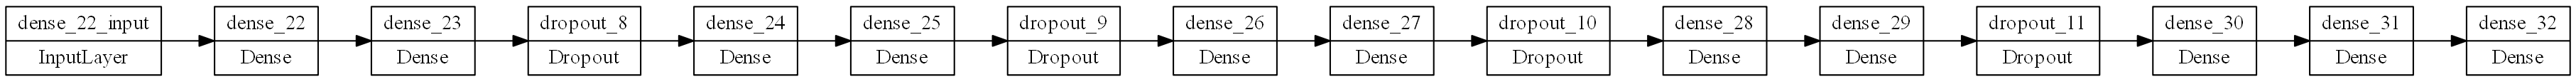

In [17]:
plot_model(
    tuned_model, to_file='tuned_model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='LR', expand_nested=False, dpi=150,
    layer_range=None, show_layer_activations=False
)

# Droput Model

In [18]:
mlp_model_dropout = Sequential(
    [
        Dense(24 ,input_dim = 12, activation='relu'),
        Dense(24 , activation='relu'),
        Dropout(0.1, seed=42),
        Dense(24 , activation='relu'),
        Dense(24 , activation='relu'),
        Dropout(0.1, seed=42),
        Dense(24 , activation='relu'),
        Dense(24 , activation='relu'),
        Dropout(0.1, seed=42),
        Dense(24 , activation='relu'),
        Dense(24 , activation='relu'),
        Dropout(0.1, seed=42),
        Dense(24 , activation='relu'),
        Dense(12 , activation='relu'),
        Dense(1 , activation='sigmoid')
    ]
)

mlp_model_dropout.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

mlp_model_dropout.fit(X_train,y_train,epochs = 150, callbacks=[early_stopping],validation_split=0.2)

Epoch 1/150
1050/1050 [==============================] - 2s 1ms/step - loss: 0.4235 - accuracy: 0.7947 - val_loss: 0.2876 - val_accuracy: 0.8708
Epoch 2/150
1050/1050 [==============================] - 1s 1ms/step - loss: 0.2702 - accuracy: 0.8775 - val_loss: 0.2366 - val_accuracy: 0.9020
Epoch 3/150
1050/1050 [==============================] - 1s 1ms/step - loss: 0.2259 - accuracy: 0.9012 - val_loss: 0.2942 - val_accuracy: 0.8602
Epoch 4/150
1050/1050 [==============================] - 1s 1ms/step - loss: 0.1950 - accuracy: 0.9142 - val_loss: 0.1802 - val_accuracy: 0.9254
Epoch 5/150
1050/1050 [==============================] - 1s 1ms/step - loss: 0.1791 - accuracy: 0.9207 - val_loss: 0.1565 - val_accuracy: 0.9307
Epoch 6/150
1050/1050 [==============================] - 1s 1ms/step - loss: 0.1689 - accuracy: 0.9267 - val_loss: 0.2066 - val_accuracy: 0.9074
Epoch 7/150
1050/1050 [==============================] - 1s 1ms/step - loss: 0.1617 - accuracy: 0.9303 - val_loss: 0.1555 - val_ac

1050/1050 [==============================] - 1s 1ms/step - loss: 0.0871 - accuracy: 0.9629 - val_loss: 0.0930 - val_accuracy: 0.9608
Epoch 58/150
1050/1050 [==============================] - 1s 1ms/step - loss: 0.0857 - accuracy: 0.9647 - val_loss: 0.0901 - val_accuracy: 0.9587
Epoch 59/150
1050/1050 [==============================] - 1s 1ms/step - loss: 0.0874 - accuracy: 0.9636 - val_loss: 0.0879 - val_accuracy: 0.9627
Epoch 60/150
1050/1050 [==============================] - 1s 1ms/step - loss: 0.0861 - accuracy: 0.9640 - val_loss: 0.0872 - val_accuracy: 0.9655
Epoch 61/150
1050/1050 [==============================] - 1s 1ms/step - loss: 0.0846 - accuracy: 0.9642 - val_loss: 0.0868 - val_accuracy: 0.9633
Epoch 62/150
1050/1050 [==============================] - 1s 1ms/step - loss: 0.0863 - accuracy: 0.9635 - val_loss: 0.1019 - val_accuracy: 0.9567
Epoch 63/150
1050/1050 [==============================] - 1s 1ms/step - loss: 0.0869 - accuracy: 0.9641 - val_loss: 0.0832 - val_accuracy

In [19]:
mlp_model_dropout.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 24)                312       
                                                                 
 dense_34 (Dense)            (None, 24)                600       
                                                                 
 dropout_12 (Dropout)        (None, 24)                0         
                                                                 
 dense_35 (Dense)            (None, 24)                600       
                                                                 
 dense_36 (Dense)            (None, 24)                600       
                                                                 
 dropout_13 (Dropout)        (None, 24)                0         
                                                                 
 dense_37 (Dense)            (None, 24)               

In [20]:
y_pred = mlp_model_dropout.predict(X_test)
y_pred = (y_pred > 0.5)

report = classification_report(y_test,y_pred, output_dict = True)
cr = pd.DataFrame(report).transpose()
print(cr)

              precision    recall  f1-score       support
0              0.963706  0.983185  0.973348  11478.000000
1              0.969316  0.934836  0.951764   6522.000000
accuracy       0.965667  0.965667  0.965667      0.965667
macro avg      0.966511  0.959011  0.962556  18000.000000
weighted avg   0.965739  0.965667  0.965528  18000.000000
